In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, make_scorer, cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier

### Load the data

In [2]:
data = pd.read_csv('train.csv')
data['Class'].value_counts()

LIVE    81
DIE     21
Name: Class, dtype: int64

### Cleaning

In [3]:

# Replace value 'c' in column 'col' with the mean of column 'col'.
def replace_by_mean(data, col, c):
    data[col].mask(data[col] == c, 0, inplace=True)
    data[col] = pd.to_numeric(data[col])
    data[col].mask(data[col] == 0, data[col].mean(), inplace=True)

# Clean all the data
def clean_data(data):
    df = data.copy()
    df['SEX'] = df['SEX'].replace({'m':'M', 'meale':'M', 'Male':'M',
                                   'maled':'M', 'male':'M', 'Feamle':'F',
                                   'female':'F'})
    replace_by_mean(df, 'PROTIME', '?')
    replace_by_mean(df, 'STEROID', '?')
    replace_by_mean(df, 'ANTIVIRALS', '?')
    replace_by_mean(df, 'FATIGUE', '?')
    replace_by_mean(df, 'MALAISE', '?')
    replace_by_mean(df, 'ANOREXIA', '?')
    replace_by_mean(df, 'LIVER BIG', '?')
    replace_by_mean(df, 'LIVER FIRM', '?')
    replace_by_mean(df, 'SPIDERS', '?')
    replace_by_mean(df, 'SPLEEN PALPABLE', '?')
    replace_by_mean(df, 'ASCITES', '?')
    replace_by_mean(df, 'BILIRUBIN', '?')
    replace_by_mean(df, 'ALK PHOSPHATE', '?')
    replace_by_mean(df, 'VARICES', '?')
    replace_by_mean(df, 'SGOT', '?')
    replace_by_mean(df, 'ALBUMIN', '?')
    replace_by_mean(df, 'HISTOLOGY', '?')
    
    return df

In [4]:
# Apply cleaning function
data = clean_data(data)
data.head()

,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY,Class
0,48,M,1.0,2,1,1,2,2.0,1.0,2.0,1.0,1.0,1.0,4.8,123.000000,157.0,2.7,31.0,2,DIE
1,51,M,2.0,2,1,2,2,2.0,1.0,1.0,1.0,2.0,1.0,1.0,86.813725,20.0,3.0,63.0,2,LIVE
2,40,M,1.0,2,1,2,2,2.0,1.0,2.0,2.0,2.0,2.0,0.6,62.000000,166.0,4.0,63.0,1,LIVE
3,25,M,2.0,2,1,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.3,181.000000,181.0,4.5,57.0,2,LIVE
4,34,M,1.0,2,1,2,2,1.0,1.0,2.0,1.0,2.0,2.0,1.0,72.000000,46.0,4.4,57.0,1,LIVE


### Upsampling

In [5]:
# Upsampling (Get rid of imbalance in column 'Class' [DIE < LIVE])
die  = data[data['Class']=='DIE']
live = data[data['Class']=='LIVE']

die2 = resample(die, replace = True, n_samples = len(live))

data = pd.concat([die2, live])
data['Class'].value_counts()

DIE     81
LIVE    81
Name: Class, dtype: int64

### X/y Split

In [6]:
# Do the X/y split to seperate dependent from independent columns
X = data.drop('Class', axis=1)
y = data['Class']

### Encode categoricals

In [7]:
# Encode categorical columns to numerical (There's only one!)
X = pd.get_dummies(X, drop_first=True)

### Train/Test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Apply StandardScaler
We have to do this, since LogisticRegression work better then

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

with open('standard_scaler.pickle', 'wb') as file:
    pickle.dump(scaler, file)

### Perform a GridSearch for RandomForestClassifier

In [10]:
params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_leaf': [2,4],
    'min_samples_split': [2,4]
}

In [11]:
gs = GridSearchCV(estimator=RandomForestClassifier(),
                  param_grid=params, cv=5)
gs.fit(X_train_scaled, y_train)    

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'min_samples_leaf': [2, 4],
                         'min_samples_split': [2, 4]})

In [12]:
gs.best_params_

{'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 4}

In [13]:
y_train_pred = gs.predict(X_train_scaled)
y_test_pred  = gs.predict(X_test_scaled)
cohen_kappa_score(y_test, y_test_pred)

0.8782287822878229

In [14]:
with open('random_forest.pickle', 'wb') as file:
    pickle.dump(gs.best_estimator_, file)

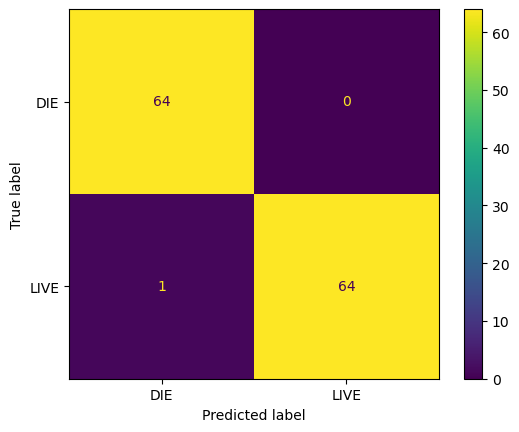

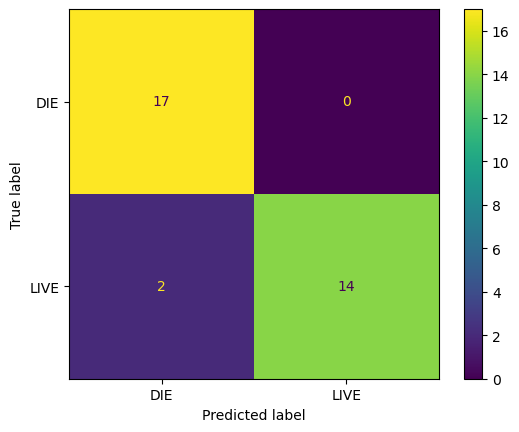

In [15]:
# Plot confusion matrix for train set prediction
cm_train = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(cm_train, display_labels=gs.best_estimator_.classes_).plot()
plt.show()

# Plot confusion matrix for test set prediction
cm_test = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm_test, display_labels=gs.best_estimator_.classes_).plot()
plt.show()

In [16]:
results = cross_val_score(gs.best_estimator_, X_train_scaled, y_train, cv=5)
print(f"Average accuracy: {results.mean()}")
results = cross_val_score(gs.best_estimator_, X_test_scaled, y_test, cv=5)
print(f"Average accuracy: {results.mean()}")

Average accuracy: 0.9227692307692308
Average accuracy: 0.7857142857142857


### Perform a GridSearch for LogisticRegression

In [17]:
params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver' : ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'],
    'max_iter': [300]
}

gs = GridSearchCV(estimator=LogisticRegression(), param_grid=params, cv=5)
gs.fit(X_train_scaled, y_train)

/home/peilnix/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/peilnix/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/peilnix/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/peilnix/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/peilnix/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/peilnix/.local/lib/python3.10/site-packages/sklearn/linear_model/_log

/home/peilnix/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/peilnix/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
45 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/peilnix/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/peilnix/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'max_iter': [300],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag',
                                    'saga']})

In [18]:
# Show best parameters for LogisticRegression
gs.best_params_

{'max_iter': 300, 'penalty': 'none', 'solver': 'lbfgs'}

In [19]:
# Store model
with open('logistic_reg.pickle', 'wb') as file:
    pickle.dump(gs.best_estimator_, file)

In [20]:
y_train_pred = gs.predict(X_train_scaled)
y_test_pred  = gs.predict(X_test_scaled)
cohen_kappa_score(y_test, y_test_pred)

0.6961325966850829

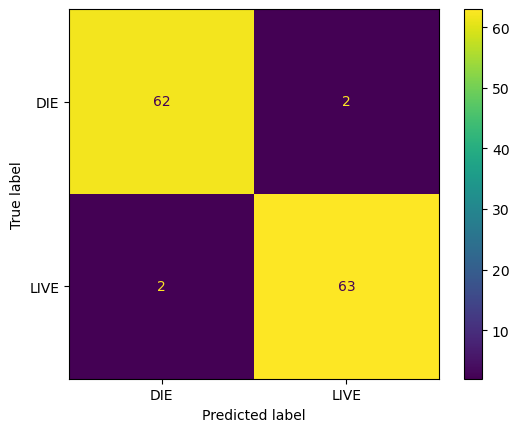

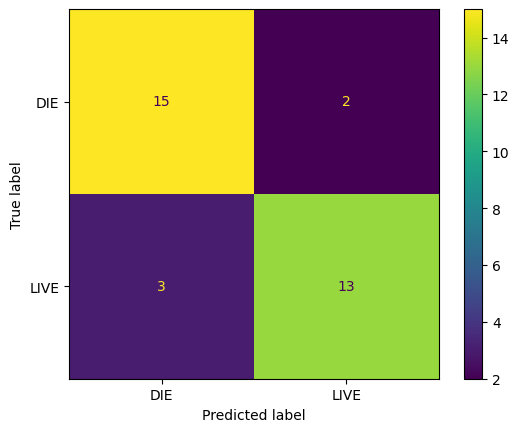

In [21]:
# Plot confusion matrix 
cm_train = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(cm_train, display_labels=gs.best_estimator_.classes_).plot()
plt.show()

cm_test = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm_test, display_labels=gs.best_estimator_.classes_).plot()
plt.show()

In [22]:
results = cross_val_score(gs.best_estimator_, X_train_scaled, y_train, cv=5)
print(f"Average accuracy: {results.mean()}")
results = cross_val_score(gs.best_estimator_, X_test_scaled, y_test, cv=5)
print(f"Average accuracy: {results.mean()}")

/home/peilnix/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/peilnix/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

Average accuracy: 0.9224615384615384
Average accuracy: 0.7857142857142858


### Perform a GridSearch for KNN-Classifier

In [23]:
params = {
    'n_neighbors': [3, 5, 8, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

gs = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params, cv=5, verbose=3)
gs.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.731 total time=   0.1s
[CV 2/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.769 total time=   0.0s
[CV 3/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.846 total time=   0.0s
[CV 4/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.654 total time=   0.0s
[CV 5/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.760 total time=   0.0s
[CV 1/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=0.769 total time=   0.1s
[CV 2/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=0.769 total time=   0.1s
[CV 3/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=0.846 total time=   0.0s
[CV 4/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=0.731 total time=   0.0s
[CV 5/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=0.800 total time=   0.0s
[CV

[CV 1/5] END algorithm=kd_tree, n_neighbors=5, weights=uniform;, score=0.692 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, n_neighbors=5, weights=uniform;, score=0.731 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, n_neighbors=5, weights=uniform;, score=0.808 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, n_neighbors=5, weights=uniform;, score=0.731 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, n_neighbors=5, weights=uniform;, score=0.560 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, n_neighbors=5, weights=distance;, score=0.731 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, n_neighbors=5, weights=distance;, score=0.808 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, n_neighbors=5, weights=distance;, score=0.846 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, n_neighbors=5, weights=distance;, score=0.731 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, n_neighbors=5, weights=distance;, score=0.760 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, n_n

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 5, 8, 10],
                         'weights': ['uniform', 'distance']},
             verbose=3)

In [24]:
y_train_pred = gs.predict(X_train_scaled)
y_test_pred  = gs.predict(X_test_scaled)
cohen_kappa_score(y_test, y_test_pred)

0.6938775510204082

In [25]:
results = cross_val_score(gs.best_estimator_, X_train_scaled, y_train, cv=5)
print(f"Average accuracy: {results.mean()}")
results = cross_val_score(gs.best_estimator_, X_test_scaled, y_test, cv=5)
print(f"Average accuracy: {results.mean()}")

Average accuracy: 0.7830769230769231
Average accuracy: 0.6333333333333333


In [26]:
with open('knn.pickle', 'wb') as file:
    pickle.dump(gs.best_estimator_, file)